In [1]:
import pandas as pd

task = 2
# only use surface solar radiation (169), surface thermal radiation (175) and top net solar radiation (178)
predictors = pd.read_csv(f'data/Task {task}/predictors{task}.csv', parse_dates=['TIMESTAMP'])\
    [['ZONEID', 'TIMESTAMP', 'VAR169', 'VAR175', 'VAR178']].set_index('TIMESTAMP')
train = pd.read_csv(f'data/Task {task}/train{task}.csv', parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')
benchmark = pd.read_csv(f"data/Task {task}/benchmark{'0' + str(task) if task < 10 else task}.csv",
                        parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')

In [2]:
solar_plants = [train[train['ZONEID'] == i][['POWER']].rename({'POWER': f'ZONEID {i}'}, axis='columns')
                for i in [1,2,3]]
train_data = pd.concat(solar_plants, axis=1)
train_data

,ZONEID 1,ZONEID 2,ZONEID 3
TIMESTAMP,,,
2012-04-01 01:00:00,0.754103,0.647328,0.799000
2012-04-01 02:00:00,0.555000,0.621822,0.817500
2012-04-01 03:00:00,0.438397,0.472692,0.571500
2012-04-01 04:00:00,0.145449,0.098866,0.063775
2012-04-01 05:00:00,0.111987,0.104393,0.103700
...,...,...,...
2013-04-30 20:00:00,0.000000,0.000000,0.000000
2013-04-30 21:00:00,0.002308,0.001680,0.004350
2013-04-30 22:00:00,0.063077,0.057530,0.130300


In [3]:
predictors_categories = [predictors[predictors['ZONEID'] == i][['VAR169', 'VAR175', 'VAR178']]
                             .rename({'VAR169': f'SURFACE SOLAR RADIATION {i}',
                                      'VAR175': f'SURFACE THERMAL RADIATION {i}',
                                      'VAR178': f'TOP NET SOLAR RADIATION {i}'}, axis='columns')
                         for i in [1,2,3]]
predictor_data = pd.concat(predictors_categories, axis=1)[:'2013-05-01 00:00']
# April is prediction month
predictor_data

,SURFACE SOLAR RADIATION 1,SURFACE THERMAL RADIATION 1,TOP NET SOLAR RADIATION 1,SURFACE SOLAR RADIATION 2,SURFACE THERMAL RADIATION 2,TOP NET SOLAR RADIATION 2,SURFACE SOLAR RADIATION 3,SURFACE THERMAL RADIATION 3,TOP NET SOLAR RADIATION 3
TIMESTAMP,,,,,,,,,
2012-04-01 01:00:00,2577830.0,1202532.0,2861797.0,2595302.0,1192092.0,2884677.0,2606438.0,1158284.0,2901861.0
2012-04-01 02:00:00,5356093.0,2446757.0,5949378.0,5374973.0,2420485.0,5984578.0,5352637.0,2341093.0,5980930.0
2012-04-01 03:00:00,7921788.0,3681336.0,8939176.0,7858492.0,3643656.0,8929064.0,7714300.0,3531304.0,8822632.0
2012-04-01 04:00:00,9860520.0,4921504.0,11331679.0,9719720.0,4885120.0,11258463.0,9619368.0,4740096.0,11178847.0
2012-04-01 05:00:00,11143097.0,6254380.0,13105558.0,11054009.0,6211372.0,13079318.0,11054009.0,6014412.0,13079958.0
...,...,...,...,...,...,...,...,...,...
2013-04-30 20:00:00,7660269.0,23632608.0,10092771.0,6776557.0,23596000.0,9423971.0,6009325.0,23165536.0,8828003.0
2013-04-30 21:00:00,7666523.0,24855424.0,10108621.0,6783323.0,24789632.0,9439821.0,6016603.0,24302592.0,8843853.0
2013-04-30 22:00:00,7884472.0,26125232.0,10490204.0,7041208.0,26000688.0,9850588.0,6336696.0,25420208.0,9301340.0


In [4]:
# define the parameters of the dataset
gefcom14_metadata = {'num_series': 3,
                     'num_steps': 24 * (365 + 30),
                     'prediction_length': 24 * 30, # 1 month (April)
                     'freq': '1H',
                     'start': [pd.Timestamp("2012-04-01 01:00", freq='1H')
                               for _ in range(3)]
                     }

In [5]:
target = train_data[:-gefcom14_metadata['prediction_length']]['ZONEID 1'].values
start = gefcom14_metadata['start'][0]
features = predictor_data[:-gefcom14_metadata['prediction_length']][['SURFACE SOLAR RADIATION 1', 'SURFACE THERMAL RADIATION 1', 'TOP NET SOLAR RADIATION 1']].values.T

In [6]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

train_ds = ListDataset([{
    FieldName.TARGET: target,
    FieldName.START: start,
    FieldName.FEAT_DYNAMIC_REAL: features
}], freq=gefcom14_metadata['freq'])

In [7]:
target = train_data['ZONEID 1'].values
start = gefcom14_metadata['start'][0]
features = predictor_data[['SURFACE SOLAR RADIATION 1', 'SURFACE THERMAL RADIATION 1', 'TOP NET SOLAR RADIATION 1']].values.T

In [8]:
test_ds = ListDataset([{
    FieldName.TARGET: target,
    FieldName.START: start,
    FieldName.FEAT_DYNAMIC_REAL: features
}], freq=gefcom14_metadata['freq'])

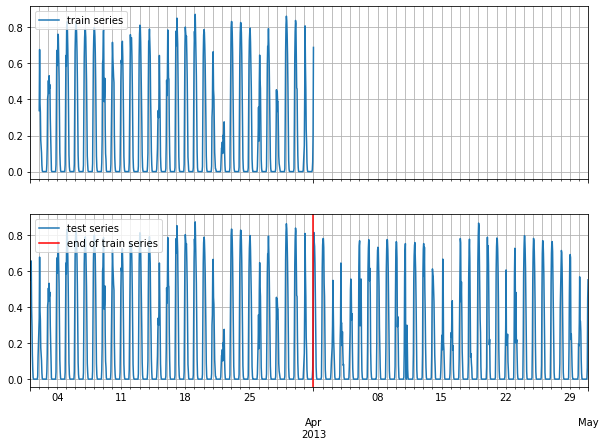

In [9]:
from gluonts.dataset.util import to_pandas
import matplotlib.pyplot as plt

train_entry = next(iter(train_ds))
test_entry = next(iter(test_ds))

train_series = to_pandas(train_entry)
test_series = to_pandas(test_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series[-24*30:].plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series[-24*61:].plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [10]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

estimator = DeepAREstimator(freq=gefcom14_metadata['freq'],
                            prediction_length=gefcom14_metadata['prediction_length'],
                            trainer=Trainer(epochs=5))
predictor = estimator.train(train_ds)

Multiprocessing is not supported on Windows, num_workers will be set to None.
100%|██████████| 50/50 [01:08<00:00,  1.37s/it, epoch=5/5, avg_epoch_loss=-2.95]


learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


In [11]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=1,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]

print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 1
Dimension of samples: (1, 720)
Start date of the forecast window: 2013-04-01 01:00:00
Frequency of the time series: 1H


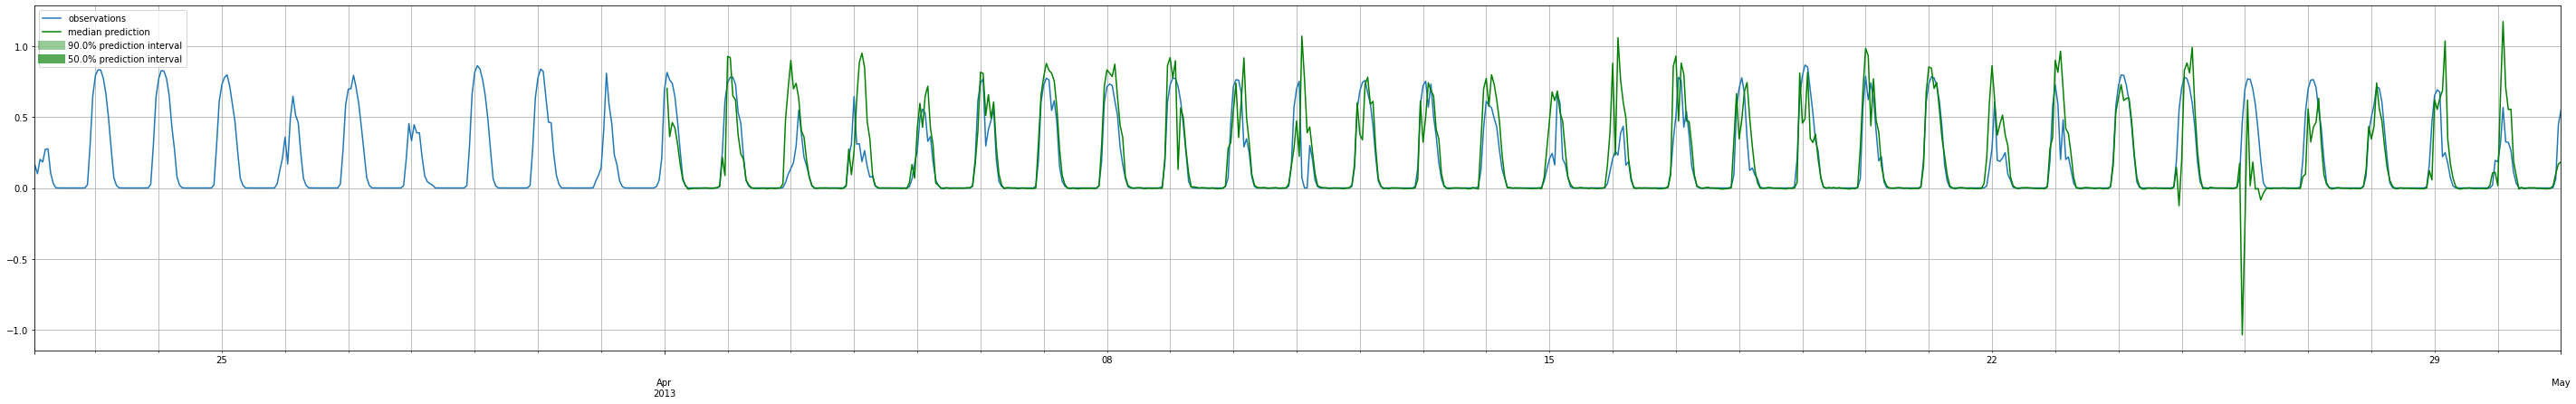

In [12]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 24 * 40
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(50, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.savefig('graph.png')
    plt.show()

plot_prob_forecasts(ts_entry, forecast_entry)
